In [1]:
import npdists
import numpy as np
import matplotlib.pyplot as plt
import prism
import emcee
import corner

This example uses emcee 2.2.1 (3.0 will have API-breaking changes)

In [2]:
print(emcee.__version__)

2.2.1


In [3]:
# set the seed so results are the same each time
# comment out to have random be... random
np.random.seed(42)

# Fake Dataset and Model

In [4]:
def run_model(x, a, b, c):
    return a*x**2+b*x+c

In [5]:
# Choose the "true" parameters.
a_true = 0.437
b_true = -2.365
c_true = 1.6
f_true = 0.086

# Generate some synthetic data from the model.
N = 25
xs = np.sort(10*np.random.rand(N))
yerrs = 0.1+0.5*np.random.rand(N)
ys = run_model(xs, a_true, b_true, c_true)
ys += np.abs(f_true*ys) * np.random.randn(N)
ys += yerrs * np.random.randn(N)

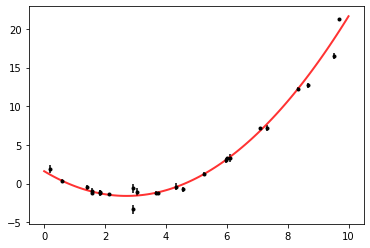

In [6]:
xl = np.linspace(0,10,101)
out = plt.plot(xl, run_model(xl, a_true, b_true, c_true), color="r", lw=2, alpha=0.8)

out = plt.errorbar(xs, ys, yerr=yerrs, fmt=".k")

# Definite Initial PDFs

Note that PRISM only accepts uniform/boxcar distributions.

In [7]:
a_init = npdists.uniform(0, 1)
b_init = npdists.uniform(-5, 0)
c_init = npdists.uniform(-1, 5)

lnf_init = npdists.uniform(-10,1)


# Would like to do this on a wider parameter-space, but getting
# distributions for MCMC will then be prohibitively expensive.
# See https://github.com/1313e/PRISM/issues/26
#a_init = npdists.uniform(-10, 10)
#b_init = npdists.uniform(-10, 10)
#c_init = npdists.uniform(-10, 10)

#lnf_init = npdists.uniform(-10,1)

And let's visualize what our initial distributions look like in model-space.

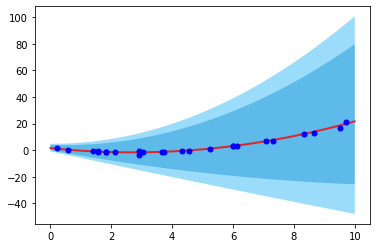

In [8]:
npdists.plot_func_from_dists((a_init, b_init, c_init), run_model, np.linspace(0,10,101))
line = plt.plot(xl, run_model(xl, a_true, b_true, c_true), color="r", lw=2, alpha=0.8)
artists = plt.errorbar(xs, ys, yerr=yerrs, fmt="b.", ms=10)

# PRISM run

In [9]:
class QuadModel(prism.modellink.ModelLink):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_default_model_parameters(self):
        par_dict = {'a': [-100,100], 'b': [-100,100], 'c': [-100,100]}
        return par_dict

    def get_default_model_data(self):                  
        data_dict = {}
        return data_dict

    def call_model(self, emul_i, par_set, data_idx):
        return run_model(np.array(data_idx), **par_set)

    def get_md_var(self, emul_i, par_set, data_idx):
        super().get_md_var(emul_i, par_set, data_idx)

In [10]:
# convert npdists (to uniform first if necessary)
# to dictionary format for PRISM
model_parameters = {'a': [a_init.low, a_init.high], 
                    'b': [b_init.low, b_init.high], 
                    'c': [c_init.low, c_init.high]}

#print("model_parameters = ", model_parameters)

# convert arrays to dictionary for PRISM
model_data = {x: [y, yerr] for x,y,yerr in zip(xs,ys,yerrs)}

#print("model_data = ", model_data)

qm = QuadModel(model_data=model_data,
               model_parameters=model_parameters)

In [11]:
pipe = prism.Pipeline(qm, root_dir='prism_quad')

In [12]:
# see https://prism-tool.readthedocs.io/en/latest/api/prism.Pipeline.html#prism.Pipeline.construct
# for passing a grid of pre-computed models

pipe.construct(1, force=True)

Finished obtaining and distributing model realization data in 0.527 seconds, averaging 0.00105 seconds per model evaluation.


/home/kyle/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1975: RuntimeWarning: overflow encountered in true_divide
  s = divide(1, s, where=large, out=s)
/home/kyle/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1978: RuntimeWarning: invalid value encountered in multiply
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))
/home/kyle/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1978: RuntimeWarning: invalid value encountered in matmul
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))


Finished construction of emulator iteration in 31.21 seconds.


/home/kyle/.local/lib/python3.6/site-packages/prism/emulator/_emulator.py:1391: RuntimeWarning: invalid value encountered in less
  adj_var_val[adj_var_val < 0] = 0


Finished analysis of emulator iteration in 27.91 seconds, averaging 86.03 emulator evaluations per second.
There is 0.792% of parameter space remaining.

PIPELINE DETAILS

GENERAL
-------------------------------
Working directory              	'prism_quad/prism_0'
Emulator type                  	'default'
ModelLink subclass             	QuadModel
Emulation method               	Regression + Gaussian
Mock data used?                	No

ITERATION
-------------------------------
Emulator iteration             	1
Construction completed?        	Yes
Plausible regions?             	Yes
Projections available?         	No
-------------------------------
# of model evaluation samples  	500 ([500])
# of plausible/analyzed samples	19/2400
% of parameter space remaining 	0.792%
# of active/total parameters   	3/3
# of emulated data points      	25
# of emulator systems          	25
-------------------------------

PARAMETER SPACE
-------------------------------
*a: [ 0.0, 1.0]
*b: [-5.0, 0.0]
*c: 

/home/kyle/.local/lib/python3.6/site-packages/prism/_pipeline.py:2718: RequestWarning: Number of plausible samples is lower than the number of samples in the first iteration (19 < 500). Constructing the next iteration might not produce a more accurate emulator.
  self.analyze()


We want a larger percentage of plausible regions, so let's check to see the implausibility values (per data-point) at the known true model.

In [13]:
# per-point (idx, sorted by implausibility) residuals in sigma-units
# between proposed model and the data
print(np.sort(pipe.evaluate({'a': [a_true], 'b': [b_true], 'c': [c_true]})['uni_impl_val']))

[[0.01921826 0.04252114 0.05481834 0.14512532 0.15167922 0.16384963
  0.23350966 0.2407038  0.27515355 0.31496024 0.41732805 0.42022143
  0.43300334 0.49412856 0.56102067 0.76120336 0.85362337 0.87467064
  0.92816234 0.95438299 1.26908108 1.61868641 1.83476701 2.18978131
         nan]]


In [14]:
pipe.analyze(impl_cut=[0, 0, 10, 8, 6, 4])

Finished analysis of emulator iteration in 30.79 seconds, averaging 78.08 emulator evaluations per second.
There is 4.42% of parameter space remaining.

PIPELINE DETAILS

GENERAL
-------------------------------
Working directory              	'prism_quad/prism_0'
Emulator type                  	'default'
ModelLink subclass             	QuadModel
Emulation method               	Regression + Gaussian
Mock data used?                	No

ITERATION
-------------------------------
Emulator iteration             	1
Construction completed?        	Yes
Plausible regions?             	Yes
Projections available?         	No
-------------------------------
# of model evaluation samples  	500 ([500])
# of plausible/analyzed samples	106/2400
% of parameter space remaining 	4.42%
# of active/total parameters   	3/3
# of emulated data points      	25
# of emulator systems          	25
-------------------------------

PARAMETER SPACE
-------------------------------
*a: [ 0.0, 1.0]
*b: [-5.0, 0.0]
*c: [

/home/kyle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RequestWarning: Number of plausible samples is lower than the number of samples in the first iteration (106 < 500). Constructing the next iteration might not produce a more accurate emulator.
  """Entry point for launching an IPython kernel.


In [15]:
# re-evaluate the remaining parameter space using the emulator
# so we can see the distributions, load in npdists, and pass
# to emcee

# See https://github.com/1313e/PRISM/issues/26 for speeding this up
n_walkers, p0_walkers = prism.utils.get_walkers(pipe, init_walkers=5000)

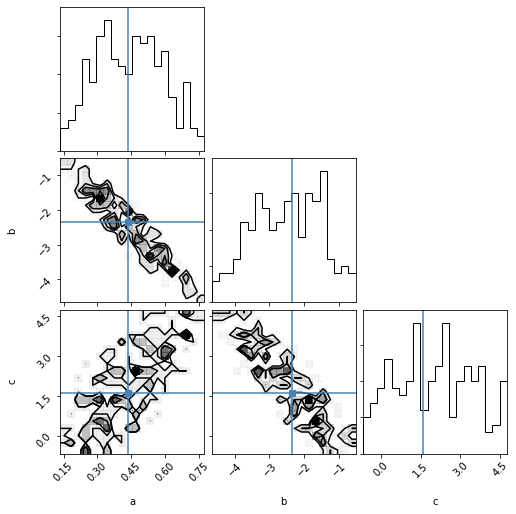

In [16]:
fig = corner.corner(p0_walkers, 
                    labels=list(model_parameters.keys()), 
                    truths=[a_true, b_true, c_true])

# Load output of PRISM into npdists

This isn't necessary, you could pass p0_walkers directly to emcee (as `ipos` in the next section)... but by loading into npdists we will eventually be able to represent as a multivariate gaussian (if applicable).

In [17]:
mvh_post_prism = npdists.mvhistogram_from_data(p0_walkers, bins=20, label=['a', 'b', 'c'])

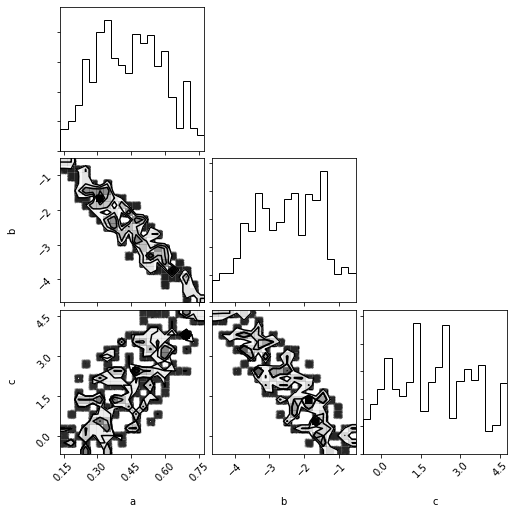

In [18]:
fig = mvh_post_prism.plot(show=True)

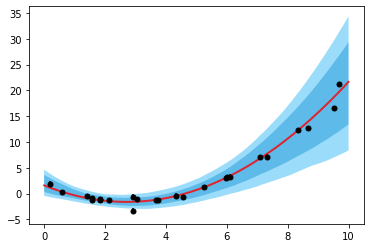

In [19]:
npdists.plot_func_from_dists(mvh_post_prism, run_model, np.linspace(0,10,101))
line = plt.plot(xl, run_model(xl, a_true, b_true, c_true), color="r", lw=2, alpha=0.8)
artists = plt.errorbar(xs, ys, yerr=yerrs, fmt="k.", ms=10)

# Sample from the new PDFs in EMCEE

Define log likelihood and log probability functions for EMCEE.

In [20]:
def lnlike(values, xs, ys, yerrs):
    a, b, c, lnf = values
        
    model = run_model(xs, a, b, c)
    inv_sigma2 = 1.0/(yerrs**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((ys-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [21]:
def lnprob(values, xs, ys, yerrs, priors):
    lp = npdists.logp_from_dists(priors, values) # WILL (eventually) account for multivariate correlations
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(values, xs, ys, yerrs)
    

First define a helper-function to filter the output chains from emcee for some burning and cutoff in lnprobability.

In [22]:
def filter_chains(lnprobability, chain, burnin=0, lnproblim=-np.inf):
    # lnprobability has shape (nwalkers, niters)
    # chain has shape (nwalkers, niters, nparams)
    chain = chain[:, burnin:, :]
    lnprobability = lnprobability[:, burnin:]
    
    keep_chain_inds = np.asarray([i for i,lnprob in enumerate(lnprobability) if np.all(lnprob > lnproblim) and np.all(np.isfinite(lnproblim))])
    nparams = chain.shape[-1]
    
    return lnprobability[keep_chain_inds, :], chain[keep_chain_inds, :, :]

Create our initial samples using both the correlated output from PRISM (via npdists) and an independent initial distribution for lnf.

In [23]:
ndim, nwalkers = 4, 100
# we'll sample from the correlated output distributions
# from PRISM for a, b, and c, but from the initial PDF
# for lnf (since that couldn't be included in PRISM)
dists = (mvh_post_prism.take_dimension('a'), 
         mvh_post_prism.take_dimension('b'), 
         mvh_post_prism.take_dimension('c'),
         lnf_init)

ipos = np.asarray(npdists.sample_from_dists(dists, size=nwalkers))

In [24]:
ipos.shape, (nwalkers, ndim)

((100, 4), (100, 4))

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(xs, ys, yerrs, ()))

In [26]:
pos, prob, state = sampler.run_mcmc(ipos, 5000)

In [27]:
lnprobability, chain = filter_chains(sampler.lnprobability, sampler.chain, burnin=100, lnproblim=-25)

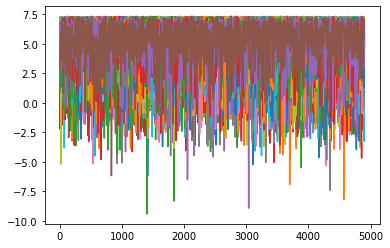

In [28]:
for lnp in lnprobability:
    plt.plot(range(len(lnp)), lnp)

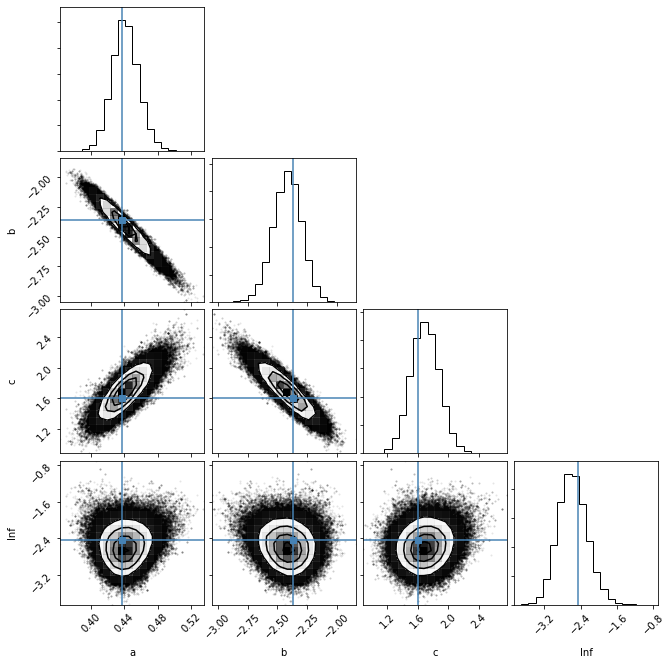

In [29]:
fig = corner.corner(chain.reshape((-1, ndim)),
                   labels=['a', 'b', 'c', 'lnf'], 
                   truths=[a_true, b_true, c_true, np.log(f_true)])

# Loud output into npdists posteriors

In [30]:
mvh_post_emcee = npdists.mvhistogram_from_data(chain.reshape((-1,ndim)), bins=20, label=['a', 'b', 'c', 'lnf'])

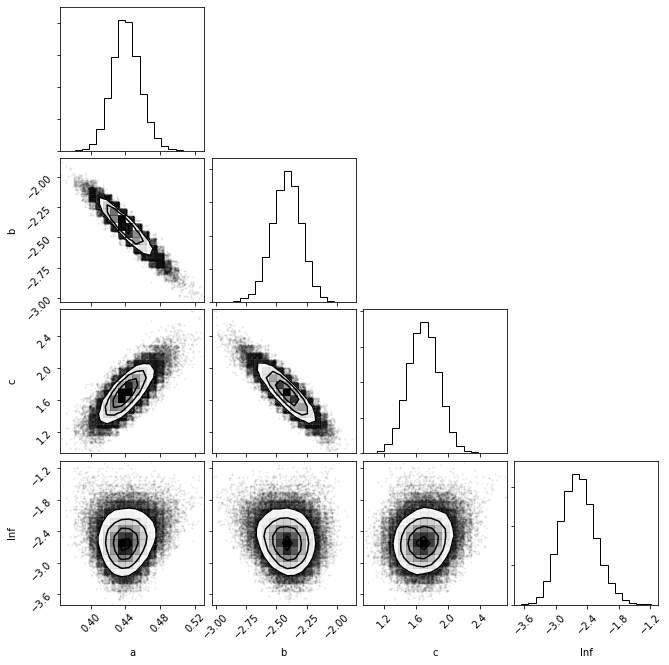

In [31]:
fig = mvh_post_emcee.plot(show=True)

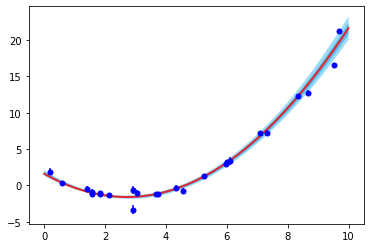

In [32]:
npdists.plot_func_from_dists(mvh_post_emcee.take_dimension(['a', 'b', 'c']), run_model, np.linspace(0,10,101))
line = plt.plot(xl, run_model(xl, a_true, b_true, c_true), color="r", lw=2, alpha=0.8)
artists = plt.errorbar(xs, ys, yerr=yerrs, fmt="b.", ms=10)